## Gaussian Mixture Model 
This notebook performs 2 forms of Gaussian Mixture models algorithms to find clusters in flux space on stellar data 
1) Spark ML GMM module (on RDD)
2) Sci-kit learn basic GMM on (numpy aray)
- Data has been preprocessed in Spark as dataframes and converted to numpy arrays 
- Matplotlib is used to visualize


In [1]:
import os
import numpy as np
from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel
from pyspark.mllib.linalg import Vectors, DenseMatrix
from sklearn.mixture import GMM

#path = "data/"
#in IBM workbook 
path = "/resources/data/XD/"

Xpath = os.path.join(path, "Xraw.npy")
Xerrpath = os.path.join(path, "Xerr.npy")
Ypath  = os.path.join(path, "Ystd.npy")

**Definitions for plotting from astroML (http://www.astroml.org/)

In [ ]:
from matplotlib import pyplot as plt
# Allows plots to appear in notebook
%matplotlib inline 

# From astroML (http://www.astroml.org/)
from cStringIO import StringIO as BytesIO
from scipy import interpolate

from matplotlib import image
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.transforms import Bbox
from matplotlib.patches import Ellipse
from matplotlib.pyplot  import savefig

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))


**Load data and put into colors

In [3]:
# Previously processed numpy arrays 

Xraw= np.load(Xpath)
Xerr = np.load(Xerrpath)
Ystd = np.load(Ypath)

# first define mixing matrix W and put into terms of colors 
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color
X = np.dot(Xraw, W.T)
Y = np.dot(Ystd, W.T)


**GMM from Spark Machine Learning Library

In [4]:
# Convert to RDD
Xrdd = sc.parallelize(X)
print Xrdd.take(5)


[array([ 18.3474  ,   2.57651 ,   1.4184  ,   0.634551,   0.408378]), array([ 19.8448  ,   1.24297 ,   0.5628  ,   0.244997,   0.059566]), array([ 15.3926  ,   2.24869 ,   1.0076  ,   0.361069,   0.174982]), array([ 15.8842  ,   1.87798 ,   0.6602  ,   0.193598,   0.082844]), array([  1.57286000e+01,   1.25874000e+00,   4.32600000e-01,
         1.85274000e-01,   1.49720000e-02])]


In [5]:
#Train GMM model using Spark's ML Library
model = GaussianMixture.train(Xrdd, 12, convergenceTol=0.0001,  maxIterations=100, seed=0)



In [6]:
#Get the output parameters of the model
 #weights--weight of each Gaussian Model
 #mu--means
 #sigma--covariances matrix
"""for i in range(3):
    print ("weight = ", model.weights[i], "mu = ", model.gaussians[i].mu, 
           "sigma = ", model.gaussians[i].sigma.toArray())"""

'for i in range(3):\n    print ("weight = ", model.weights[i], "mu = ", model.gaussians[i].mu, \n           "sigma = ", model.gaussians[i].sigma.toArray())'

**Sklearn GMM - from sci-kit learn library

In [7]:
# fit model to raw data
clf = GMM(n_components=12, tol=0.0001, n_iter=100, random_state=0, covariance_type ='full')
clf.fit(X)
"""for i in range(3):
        print ("\n weight = ", clf.weights_[i], "\nmu = ", clf.means_, 
           "\nsigma = ", clf.covars_[i])"""

'for i in range(3):\n        print ("\n weight = ", clf.weights_[i], "\nmu = ", clf.means_, \n           "\nsigma = ", clf.covars_[i])'

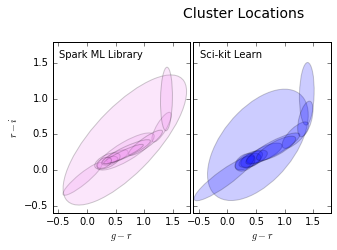

In [8]:
# Modified from AstroML (http://www.astroml.org/) to compare clusters
fig = plt.figure(figsize=(7, 6))

fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.90,
                    wspace=0.02, hspace=0.02)
fig.suptitle("Cluster Locations", fontsize=14)
# only plot 1/10 of the stars for clarity

ax1 = fig.add_subplot(231)
for i in range(12):
    draw_ellipse(np.asarray(model.gaussians[i].mu[2:4]), np.asarray(model.gaussians[i].sigma.toArray()[2:4, 2:4]), scales=[2],
                 ec='k', fc='violet', alpha=0.2, ax=ax1)
ax2 = fig.add_subplot(232)
for i in range(clf.n_components):
    draw_ellipse(clf.means_[i, 2:4], clf.covars_[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='blue', alpha=0.2, ax=ax2)

titles = ["Spark ML Library",
          "Sci-kit Learn"]
ax=[ax1,ax2]

for i in range(2):
    ax[i].set_xlim(-.6,1.8)
    ax[i].set_ylim(-.6,1.8)
    
    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

ax1.set_xlabel('$g-r$')
ax1.set_ylabel('$r-i$')

ax2.set_xlabel('$g-r$')
ax2.yaxis.set_major_formatter(plt.NullFormatter())


#savefig('plots/GMMcompare.png', bbox_inches='tight')